In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from torch.utils.tensorboard import SummaryWriter

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

simplefilter("ignore", category=ConvergenceWarning)

if not os.path.exists('results'):
    os.mkdir('results')

if not os.path.exists('results/pca'):
    os.mkdir('results/pca')

if not os.path.exists('results/no_pca'):
    os.mkdir('results/no_pca')

## Classic Machine Learning Techniques

In [2]:
is_pca = False

if is_pca:
    path = 'runs/classicMl/pca/'
    results_path = 'results/pca/'
else:
    path = 'runs/classicMl/no_pca/'
    results_path = 'results/no_pca/'

In [3]:
seed = 42
np.random.seed(seed)

df = pd.read_csv('dataset.csv')
display(df.head())
print(f'Number of samples: {df.shape[0]}')

,rating_mean,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,3.893708,0.02875,0.02375,0.06250,0.07575,0.14075,0.14675,0.06350,0.20375,0.2020,...,0,0,0,0,0,0,0,0,0,0
1,3.251527,0.04125,0.04050,0.06275,0.08275,0.09100,0.06125,0.06925,0.09600,0.0765,...,0,0,0,0,0,0,0,0,0,0
2,3.142028,0.04675,0.05550,0.02925,0.08700,0.04750,0.04775,0.04600,0.14275,0.0285,...,0,0,0,0,0,1,0,0,0,0
3,2.853547,0.03425,0.03800,0.04050,0.03100,0.06500,0.03575,0.02900,0.08650,0.0320,...,0,0,0,0,0,1,0,0,0,0
4,3.058434,0.04300,0.05325,0.03800,0.04100,0.05400,0.06725,0.02775,0.07650,0.0215,...,0,0,0,0,0,0,0,0,0,0


Number of samples: 13798


### Data Preprocessing

In [4]:
X = df.drop('rating_mean', axis=1)
y = df['rating_mean']

# Train Test and Validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=seed)

print('Number of training samples:', X_train.shape)
print('Number of testing samples:', X_test.shape)
print('Number of validation samples:', X_val.shape)

Number of training samples: (9934, 1148)
Number of testing samples: (2760, 1148)
Number of validation samples: (1104, 1148)


In [5]:
if is_pca:
    print("Applying PCA...")
    pca = PCA(n_components=0.95)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_val = pca.transform(X_val)
    X_test = pca.transform(X_test)
    print(f'Number of features after PCA: {X_train.shape[1]}')
else:
    print("PCA is not applied")

PCA is not applied


# Models
### Linear Regression

In [6]:
writer = SummaryWriter(path + 'linear_regression')

regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

writer.add_scalar('Loss', mse)
writer.flush()

print('Linear Regression Results:')
print('Mean Square Error:', mse)
print('R2 Score:', r2)

open(results_path + 'linear_regression.txt', 'w').write(f'Mean Square Error: {mse}\nR2 Score: {r2}')

Linear Regression Results:
Mean Square Error: 0.005334505742097179
R2 Score: 0.976349898145375


67

### Ridge Regression

In [7]:
from sklearn.linear_model import Ridge

parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
ridge_regressor = Ridge()

grid_search = GridSearchCV(ridge_regressor, parameters, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

print('Grid Search Results:')
print('Best Parameters:', grid_search.best_params_)
print('Best Score (negative MSE) :', grid_search.best_score_)

Grid Search Results:
Best Parameters: {'alpha': 1}
Best Score (negative MSE) : -0.005372153920632642


In [10]:
ridge_regressor = Ridge(alpha=grid_search.best_params_['alpha'])
ridge_regressor.fit(X_train, y_train)

y_pred = ridge_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Ridge Regression Results:')
print('Mean Square Error:', mse)
print('R2 Score:', r2)

Ridge Regression Results:
Mean Square Error: 0.005254995929547522
R2 Score: 0.9767023984998882


In [11]:
writer = SummaryWriter(path + 'ridge_regression')

writer.add_hparams(grid_search.best_params_, {'mse': mse})
writer.flush()

open(results_path + 'ridge_regression.txt', 'w').write(f'Mean Square Error: {mse}\nR2 Score: {r2}, \nBest Params: {grid_search.best_params_}')

96

### Lasso Regression

In [10]:
from sklearn.linear_model import Lasso

parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

lasso_regressor = Lasso()

grid_search = GridSearchCV(lasso_regressor, parameters, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

print('Grid Search Results:')
print('Best Parameters:', grid_search.best_params_)
print('Best Score (negative MSE) :', grid_search.best_score_)

Iteration: 1 | Alpha: 0.01 | MSE: 0.0317

Iteration: 2 | Alpha: 0.001 | MSE: 0.0104

Iteration: 3 | Alpha: 0.0001 | MSE: 0.0054

Iteration: 4 | Alpha: 1e-05 | MSE: 0.0051

Iteration: 5 | Alpha: 1e-06 | MSE: 0.0053

Lasso Regression Best Results:
Alpha: 1e-05
Mean Square Error: 0.005098180158555444
R2 Score: 0.9765532943400839


In [ ]:
lasso_regressor = Lasso(alpha=grid_search.best_params_['alpha'])
lasso_regressor.fit(X_train, y_train)

y_pred = lasso_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Lasso Regression Results:')a
print('Mean Square Error:', mse)
print('R2 Score:', r2)

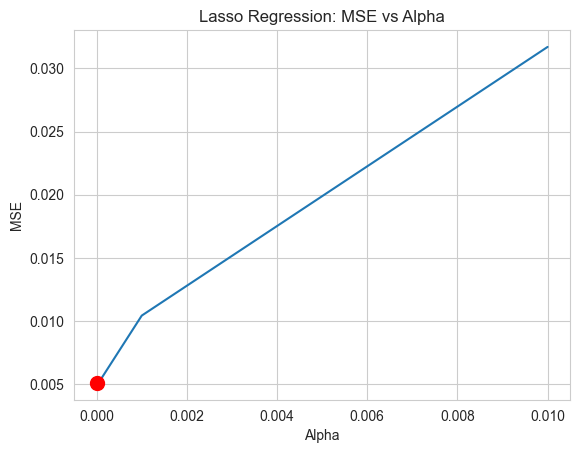

In [11]:
writer = SummaryWriter(path + 'lasso_regression')

writer.add_hparams(grid_search.best_params_, {'mse': mse})

open(results_path + 'lasso_regression.txt', 'w').write(f'Mean Square Error: {mse}\nR2 Score: {r2}\nBest Params: {grid_search.best_params_}')

### Elastic Net Regression

In [12]:
from sklearn.linear_model import ElasticNet

param_grid = {'alpha': [1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
              'l1_ratio': [0.3, 0.5, 0.7]}

elastic_net_regressor = ElasticNet()

grid_search = GridSearchCV(elastic_net_regressor, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

print('Grid Search Results:')
print('Best Parameters:', grid_search.best_params_)
print('Best Score (negative MSE) :', grid_search.best_score_)

Iteration: 1 | Alpha: 0.01 | MSE: 0.0217

Iteration: 2 | Alpha: 0.001 | MSE: 0.0081

Iteration: 3 | Alpha: 0.0001 | MSE: 0.0052

Iteration: 4 | Alpha: 1e-05 | MSE: 0.0052

Iteration: 5 | Alpha: 1e-06 | MSE: 0.0053

Elastic Net Regression Best Results:
Alpha: 0.0001
Mean Square Error: 0.00516709167911393
R2 Score: 0.976989940432127


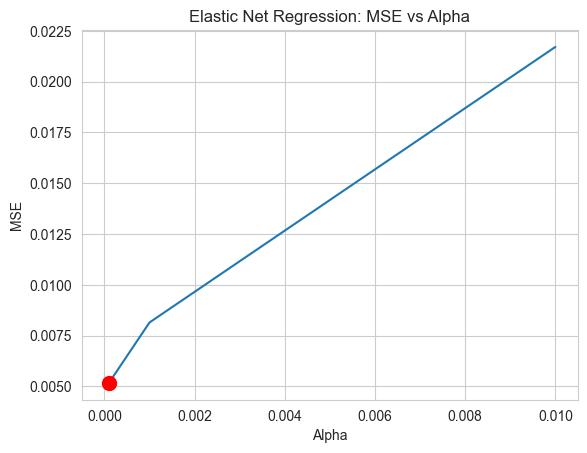

In [13]:
elastic_net_regressor = ElasticNet(alpha=grid_search.best_params_['alpha'],
                                   l1_ratio=grid_search.best_params_['l1_ratio'])
elastic_net_regressor.fit(X_train, y_train)

y_pred = elastic_net_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Elastic Net Regression Results:')
print('Mean Square Error:', mse)
print('R2 Score:', r2)

In [ ]:
writer = SummaryWriter(path + 'elastic_net_regression')

writer.add_hparams(grid_search.best_params_, {'mse': mse})

open(results_path + 'elastic_net_regression.txt', 'w').write(f'Mean Square Error: {mse}\nR2 Score: {r2}\nBest Params: {grid_search.best_params_}')

### Random Forest Regressor

In [15]:
from sklearn.ensemble import RandomForestRegressor

pram_grid = {'n_estimators': [50, 100, 150],
             'max_depth': [5, 10],
             'criterion': ['squared_error', 'friedman_mse', 'poisson']}

random_forest_regressor = RandomForestRegressor()

grid_search = GridSearchCV(random_forest_regressor, pram_grid, scoring='neg_mean_squared_error', cv=2, verbose=3)
grid_search.fit(X_train, y_train)

print('Grid Search Results:')
print('Best Parameters:', grid_search.best_params_)
print('Best Score (negative MSE) :', grid_search.best_score_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END criterion=squared_error, max_depth=2, n_estimators=5;, score=-0.067 total time=   2.7s
[CV 2/2] END criterion=squared_error, max_depth=2, n_estimators=5;, score=-0.067 total time=   2.3s
Grid Search Results:
Best Parameters: {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 5}
Best Score (negative MSE) : -0.06677967486844516


In [16]:
random_forest_regressor = RandomForestRegressor(n_estimators=grid_search.best_params_['n_estimators'],
                                                 max_depth=grid_search.best_params_['max_depth'],
                                                 criterion=grid_search.best_params_['criterion'])
random_forest_regressor.fit(X_train, y_train)

y_pred = random_forest_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Random Forest Regression Results:')
print('Mean Square Error:', mse)
print('R2 Score:', r2)

Random Forest Regression Results:
Mean Square Error: 0.06696434800656298
R2 Score: 0.7031189528045844


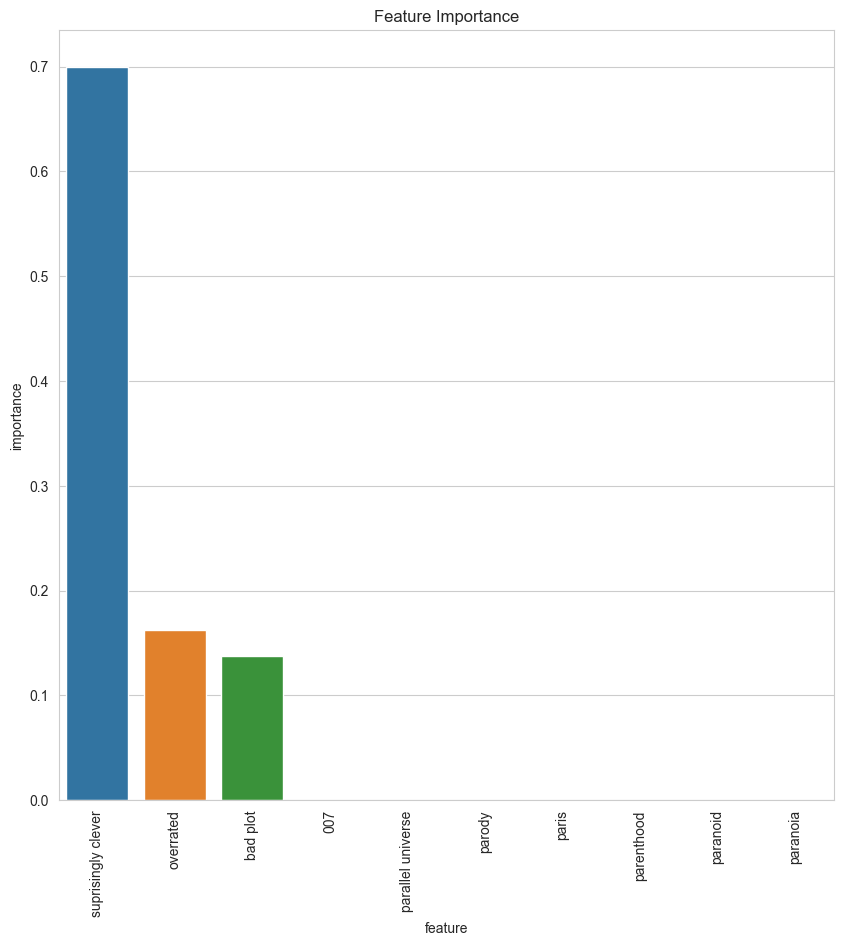

In [24]:
## Feature Importance
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': random_forest_regressor.feature_importances_})

feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x=feature_importance['feature'][:10], y=feature_importance['importance'][:10])
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.show()

In [25]:
writer = SummaryWriter(path + 'random_forest_regression')

writer.add_hparams(grid_search.best_params_, {'mse': mse})

open(results_path + 'random_forest_regression.txt', 'w').write(f'Mean Square Error: {mse}\nR2 Score: {r2}\nBest Params: {grid_search.best_params_}')

146

### Support Vector Regressor

In [20]:
from sklearn.svm import SVR

param_grid = {'C': [0.001, 0.01, 0.1, 1],
              'epsilon': [0.001, 0.01, 0.1, 1],
              'kernel': ['linear', 'poly', 'rbf']}

svr_regressor = SVR()

grid_search = GridSearchCV(svr_regressor, parameters, scoring='neg_mean_squared_error', cv=2, verbose=3)
grid_search.fit(X_train, y_train)

print('Grid Search Results:')
print('Best Parameters:', grid_search.best_params_)
print('Best Score (negative MSE) :', grid_search.best_score_)

Iteration: 1 | C: 0.001 | Epsilon: 0.001 | Kernel: linear | MSE: 0.0082

Iteration: 2 | C: 0.001 | Epsilon: 0.001 | Kernel: poly | MSE: 0.0806

Iteration: 3 | C: 0.001 | Epsilon: 0.001 | Kernel: rbf | MSE: 0.1079

Iteration: 4 | C: 0.001 | Epsilon: 0.01 | Kernel: linear | MSE: 0.0083

Iteration: 5 | C: 0.001 | Epsilon: 0.01 | Kernel: poly | MSE: 0.0807

Iteration: 6 | C: 0.001 | Epsilon: 0.01 | Kernel: rbf | MSE: 0.1080

Iteration: 7 | C: 0.001 | Epsilon: 0.1 | Kernel: linear | MSE: 0.0107

Iteration: 8 | C: 0.001 | Epsilon: 0.1 | Kernel: poly | MSE: 0.0831

Iteration: 9 | C: 0.001 | Epsilon: 0.1 | Kernel: rbf | MSE: 0.1105

Iteration: 10 | C: 0.001 | Epsilon: 1 | Kernel: linear | MSE: 0.2563

Iteration: 11 | C: 0.001 | Epsilon: 1 | Kernel: poly | MSE: 0.2826

Iteration: 12 | C: 0.001 | Epsilon: 1 | Kernel: rbf | MSE: 0.2675

Iteration: 13 | C: 0.01 | Epsilon: 0.001 | Kernel: linear | MSE: 0.0054

Iteration: 14 | C: 0.01 | Epsilon: 0.001 | Kernel: poly | MSE: 0.0242

Iteration: 15 | C:

In [ ]:
svr_regressor = SVR(C=grid_search.best_params_['C'],
                    epsilon=grid_search.best_params_['epsilon'],
                    kernel=grid_search.best_params_['kernel'])

svr_regressor.fit(X_train, y_train)

y_pred = svr_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Support Vector Regression Results:')
print('Mean Square Error:', mse)
print('R2 Score:', r2)

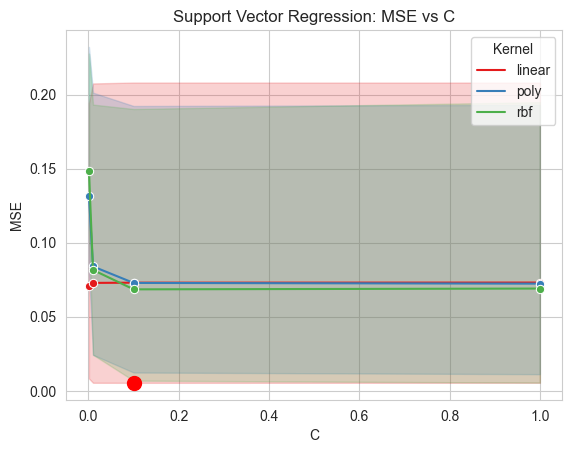

In [21]:
writer = SummaryWriter(path + 'support_vector_regression')

writer.add_hparams(grid_search.best_params_, {'mse': mse})

open(results_path + 'support_vector_regression.txt', 'w').write(f'Mean Square Error: {mse}\nR2 Score: {r2}\nBest Params: {grid_search.best_params_}')

### K-Nearest Neighbors

In [22]:
from sklearn.neighbors import KNeighborsRegressor

param_grid = {'n_neighbors': np.arange(1, 21),
              'weights': ['uniform', 'distance']}

knn_regressor = KNeighborsRegressor()

grid_search = GridSearchCV(knn_regressor, param_grid, scoring='neg_mean_squared_error', cv=2, verbose=3)

grid_search.fit(X_train, y_train)

print('Grid Search Results:')
print('Best Parameters:', grid_search.best_params_)
print('Best Score (negative MSE) :', grid_search.best_score_)

Iteration: 1 | N: 3 | Weight: uniform | MSE: 0.0539

Iteration: 2 | N: 3 | Weight: distance | MSE: 0.0536

Iteration: 3 | N: 5 | Weight: uniform | MSE: 0.0479

Iteration: 4 | N: 5 | Weight: distance | MSE: 0.0474

Iteration: 5 | N: 7 | Weight: uniform | MSE: 0.0468

Iteration: 6 | N: 7 | Weight: distance | MSE: 0.0463

Iteration: 7 | N: 9 | Weight: uniform | MSE: 0.0456

Iteration: 8 | N: 9 | Weight: distance | MSE: 0.0451

Iteration: 9 | N: 11 | Weight: uniform | MSE: 0.0452

Iteration: 10 | N: 11 | Weight: distance | MSE: 0.0447

Iteration: 11 | N: 13 | Weight: uniform | MSE: 0.0455

Iteration: 12 | N: 13 | Weight: distance | MSE: 0.0449

Iteration: 13 | N: 15 | Weight: uniform | MSE: 0.0455

Iteration: 14 | N: 15 | Weight: distance | MSE: 0.0449

Iteration: 15 | N: 17 | Weight: uniform | MSE: 0.0461

Iteration: 16 | N: 17 | Weight: distance | MSE: 0.0454

Iteration: 17 | N: 19 | Weight: uniform | MSE: 0.0466

Iteration: 18 | N: 19 | Weight: distance | MSE: 0.0460

K-Nearest Neighbor

In [ ]:
knn_regressor = KNeighborsRegressor(n_neighbors=grid_search.best_params_['n_neighbors'],
                                    weights=grid_search.best_params_['weights'])

knn_regressor.fit(X_train, y_train)

y_pred = knn_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('K-Nearest Neighbors Regression Results:')
print('Mean Square Error:', mse)
print('R2 Score:', r2)

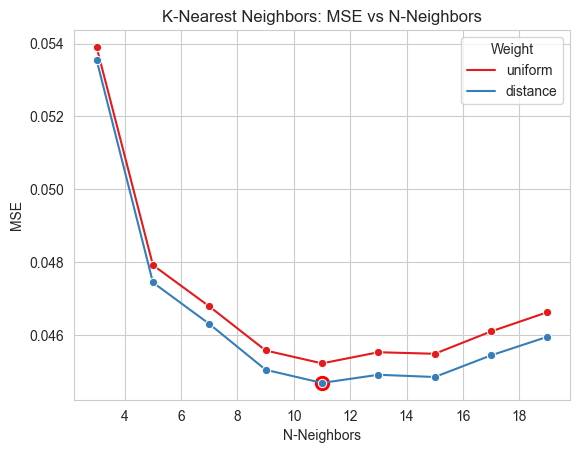

In [23]:
writer = SummaryWriter(path + 'knn_regression')

writer.add_hparams(grid_search.best_params_, {'mse': mse})

open(results_path + 'knn_regression.txt', 'w').write(f'Mean Square Error: {mse}\nR2 Score: {r2}\nBest Params: {grid_search.best_params_}')

In [24]:
writer.close()